<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/CNN_stock_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web

SID = '^TWII'
df = web.DataReader(SID,'yahoo',start="2000-01-01")
df = df.iloc[:,:5]

In [150]:
#!pip install finta
#!pip install --upgrade pandas
#!pip install --upgrade pandas-datareader

# 載入資料

In [151]:
print(df.shape)
df.head(3)

(5534, 5)


,High,Low,Open,Close,Volume
Date,,,,,
2000-01-04,8803.610352,8642.500000,8644.910156,8756.549805,0.0
2000-01-05,8867.679688,8668.019531,8690.599609,8849.870117,0.0
2000-01-06,9023.990234,8833.910156,8900.559570,8922.030273,0.0


In [152]:
df.tail(3)

,High,Low,Open,Close,Volume
Date,,,,,
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0


# Labeling(計算return)

In [153]:
#今天股價 = df['Close']
#昨天股價 = df['Close'].shift(1)
#df['return%'] = (今天股價/昨天股價-1)*100
#print(df['return%'].min(),df['return%'].max())
#sns.distplot(df['return%'].dropna())
#df.tail()

# Label triple_barrier

In [154]:
import numpy as np
import math
def triple_barrier(price, ub, lb, max_period):

    def end_price(s):
        return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
    
    r = np.array(range(max_period))
    
    def end_time(s):
        return np.append(r[(s / s[0] > ub) | (s / s[0] < lb)], max_period-1)[0]

    p = price.rolling(max_period).apply(end_price, raw=True).shift(-max_period+1)
    t = price.rolling(max_period).apply(end_time, raw=True).shift(-max_period+1)
    t = pd.Series([t.index[int(k+i)] if not math.isnan(k+i) else np.datetime64('NaT') 
                   for i, k in enumerate(t)], index=t.index).dropna()

    signal = pd.Series(0, p.index)
    signal.loc[p > ub] = 1
    signal.loc[p < lb] = -1
    ret = pd.DataFrame({'triple_barrier_profit':p, 'triple_barrier_sell_time':t, 'triple_barrier_signal':signal})

    return ret

ret = triple_barrier(df.Close,1.03,0.97,20)['triple_barrier_signal']
df = df.join(ret)

In [155]:
df.tail(20)

,High,Low,Open,Close,Volume,triple_barrier_signal
Date,,,,,,
2022-06-16,16209.250000,15838.290039,16098.290039,15838.610352,3636900.0,-1
2022-06-17,15794.160156,15573.379883,15794.160156,15641.259766,4373500.0,0
2022-06-20,15667.679688,15367.580078,15649.200195,15367.580078,3998700.0,0
2022-06-21,15728.639648,15427.330078,15427.330078,15728.639648,3553500.0,0
2022-06-22,15687.459961,15346.950195,15687.459961,15347.750000,3950300.0,0
2022-06-23,15380.280273,15102.400391,15305.509766,15176.440430,3916600.0,0
2022-06-24,15424.370117,15232.339844,15232.339844,15303.320312,3081400.0,0
2022-06-27,15656.349609,15409.080078,15409.080078,15548.009766,3120800.0,0
2022-06-28,15533.339844,15375.650391,15519.559570,15439.919922,3094700.0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


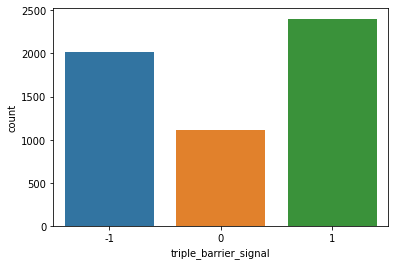

In [156]:
df['triple_barrier_signal'].value_counts()
sns.countplot(df['triple_barrier_signal'])

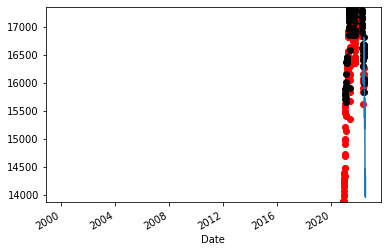

In [157]:
import matplotlib.pyplot as plt
buy = df[df['triple_barrier_signal']==1]['Close']
sell = df[df['triple_barrier_signal']==-1]['Close']
df['Close'][-40:].plot()#後20筆是前20筆的驗證
plt.scatter(buy.index,buy.values,color='red')
plt.scatter(sell.index,sell.values,color='black')
lb = df['Close'][-40:].mean() - 2*df['Close'][-40:].std()
ub = df['Close'][-40:].mean() + 2*df['Close'][-40:].std()
plt.ylim(lb,ub)
plt.show()

# 建立ohlcv

In [158]:
#!pip install finta

In [159]:
from finta import TA
ohlcv = df[['Open','High','Low','Close','Volume']]
ohlcv.columns = ['open','high','low','close','volume']

# 計算技術指標RSI

count    5533.000000
mean       52.595554
std        12.877513
min         9.948198
25%        43.173394
50%        53.283015
75%        61.942668
max       100.000000
Name: RSI, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI
Date,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778


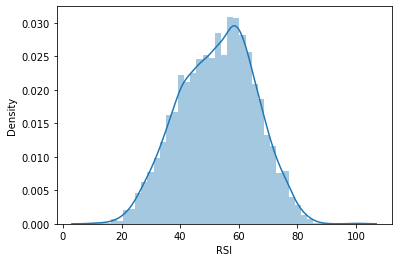

In [160]:
df['RSI'] = TA.RSI(ohlcv)
print(df['RSI'].describe())
sns.distplot(df['RSI'].dropna())
df.tail()

# 計算威廉指標

count    5521.000000
mean      -43.243804
std        32.004453
min      -100.000000
25%       -73.086478
50%       -38.123117
75%       -13.436275
max        -0.000000
Name: Williams %R, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R
Date,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084


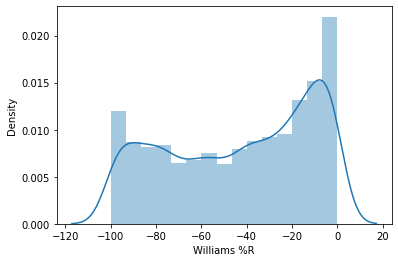

In [161]:
df['Williams %R'] = TA.WILLIAMS(ohlcv)
print(df['Williams %R'].describe())
sns.distplot(df['Williams %R'].dropna())
df.tail()

# SMA

count     5494.000000
mean      8477.350172
std       2979.064438
min       3821.469018
25%       6325.264970
50%       8067.121719
75%       9545.565793
max      18134.302258
Name: SMA, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA
Date,,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593,15772.115115
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078,15734.512195
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744,15703.386600
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940,15657.486114
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084,15619.038300


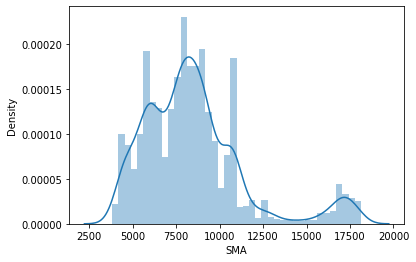

In [162]:
df['SMA'] = TA.SMA(ohlcv)
print(df['SMA'].describe())
sns.distplot(df['SMA'].dropna())
df.tail()

# EMA

count     5534.000000
mean      8500.790889
std       3000.749075
min       3570.937692
25%       6368.706063
50%       8111.679576
75%       9600.035349
max      18370.191557
Name: EMA, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA
Date,,,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593,15772.115115,14605.256311
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078,15734.512195,14577.111104
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744,15703.386600,14529.794938
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940,15657.486114,14413.959974
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084,15619.038300,14396.103916


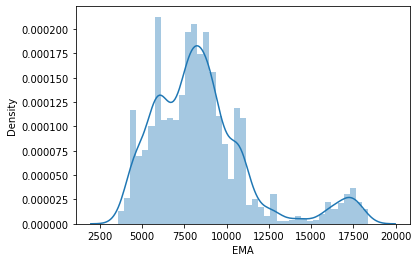

In [163]:
df['EMA'] = TA.EMA(ohlcv)
print(df['EMA'].describe())
sns.distplot(df['EMA'])
df.tail()

# WMA

count     5526.000000
mean      8501.595995
std       3006.326892
min       3527.999544
25%       6363.882042
50%       8105.086860
75%       9610.091612
max      18389.146615
Name: WMA, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA
Date,,,,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593,15772.115115,14605.256311,14440.529427
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078,15734.512195,14577.111104,14393.770833
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744,15703.386600,14529.794938,14346.289562
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940,15657.486114,14413.959974,14245.257140
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084,15619.038300,14396.103916,14247.692405


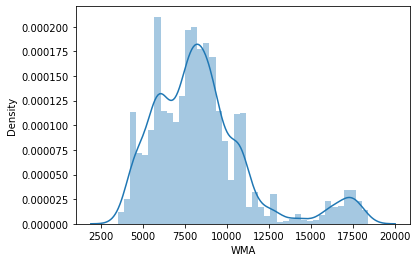

In [164]:
df['WMA'] = TA.WMA(ohlcv)
print(df['WMA'].describe())
sns.distplot(df['WMA'].dropna())
df.tail()

# HMA

count     5516.000000
mean      8502.297739
std       3015.458052
min       3433.914340
25%       6345.537452
50%       8098.834695
75%       9615.413007
max      18487.953184
Name: HMA, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA
Date,,,,,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593,15772.115115,14605.256311,14440.529427,14141.877903
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078,15734.512195,14577.111104,14393.770833,14051.781950
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744,15703.386600,14529.794938,14346.289562,14018.192797
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940,15657.486114,14413.959974,14245.257140,13987.538105
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084,15619.038300,14396.103916,14247.692405,14005.370061


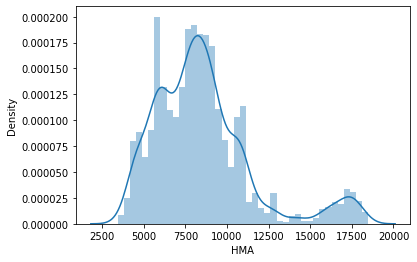

In [165]:
df['HMA'] = TA.HMA(ohlcv)
print(df['HMA'].describe())
sns.distplot(df['HMA'].dropna())
df.tail()

# TEMA

count     5534.000000
mean      8504.727181
std       3009.955513
min       3447.605265
25%       6357.216871
50%       8100.050222
75%       9609.030960
max      18516.770956
Name: TEMA, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA
Date,,,,,,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593,15772.115115,14605.256311,14440.529427,14141.877903,14068.335550
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078,15734.512195,14577.111104,14393.770833,14051.781950,14182.014299
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744,15703.386600,14529.794938,14346.289562,14018.192797,14209.159924
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940,15657.486114,14413.959974,14245.257140,13987.538105,14047.568251
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084,15619.038300,14396.103916,14247.692405,14005.370061,14137.639600


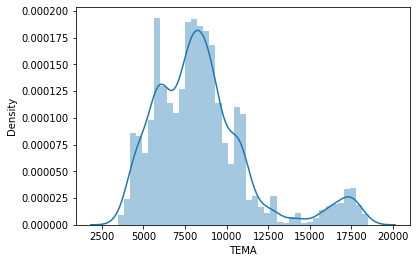

In [166]:
df['TEMA'] = TA.TEMA(ohlcv)
print(df['TEMA'].describe())
sns.distplot(df['TEMA'].dropna())
df.tail()

# CCI

count    5533.000000
mean       14.524969
std       111.387411
min      -421.723833
25%       -73.974711
50%        32.472581
75%       101.515353
max       405.786443
Name: CCI, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI
Date,,,,,,,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593,15772.115115,14605.256311,14440.529427,14141.877903,14068.335550,-129.709811
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078,15734.512195,14577.111104,14393.770833,14051.781950,14182.014299,-87.378344
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744,15703.386600,14529.794938,14346.289562,14018.192797,14209.159924,-83.790686
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940,15657.486114,14413.959974,14245.257140,13987.538105,14047.568251,-110.167836
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084,15619.038300,14396.103916,14247.692405,14005.370061,14137.639600,-71.753747


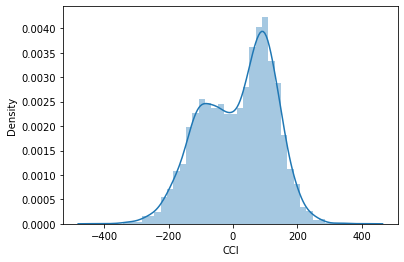

In [167]:
df['CCI'] = TA.CCI(ohlcv)
print(df['CCI'].describe())
sns.distplot(df['CCI'].dropna())
df.tail()

# CMO

count    5533.000000
mean        5.620835
std        30.223473
min       -86.464212
25%       -16.366607
50%         7.644159
75%        27.630530
max       100.000000
Name: CMO, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO
Date,,,,,,,,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593,15772.115115,14605.256311,14440.529427,14141.877903,14068.335550,-129.709811,-33.463856
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078,15734.512195,14577.111104,14393.770833,14051.781950,14182.014299,-87.378344,-26.135031
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744,15703.386600,14529.794938,14346.289562,14018.192797,14209.159924,-83.790686,-30.249407
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940,15657.486114,14413.959974,14245.257140,13987.538105,14047.568251,-110.167836,-41.612264
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084,15619.038300,14396.103916,14247.692405,14005.370061,14137.639600,-71.753747,-20.659766


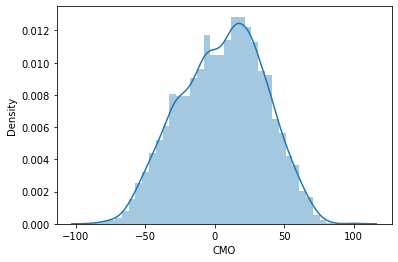

In [168]:
df['CMO'] = TA.CMO(ohlcv)
print(df['CMO'].describe())
sns.distplot(df['CMO'].dropna())
df.tail()

# MACD

count    5534.000000
mean       -0.346994
std        35.532072
min      -244.072759
25%       -19.352899
50%         0.716542
75%        20.364671
max       156.874065
Name: MACD, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD
Date,,,,,,,,,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593,15772.115115,14605.256311,14440.529427,14141.877903,14068.335550,-129.709811,-33.463856,-114.309609
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078,15734.512195,14577.111104,14393.770833,14051.781950,14182.014299,-87.378344,-26.135031,-79.686942
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744,15703.386600,14529.794938,14346.289562,14018.192797,14209.159924,-83.790686,-30.249407,-57.770036
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940,15657.486114,14413.959974,14245.257140,13987.538105,14047.568251,-110.167836,-41.612264,-61.803871
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084,15619.038300,14396.103916,14247.692405,14005.370061,14137.639600,-71.753747,-20.659766,-32.996041


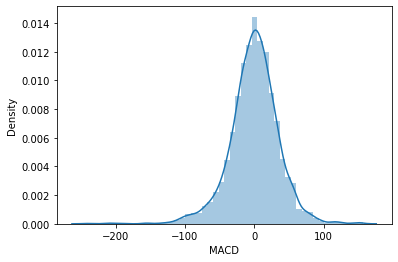

In [169]:
df['MACD'] = TA.MACD(ohlcv)['MACD'] - TA.MACD(ohlcv)['SIGNAL']
print(df['MACD'].describe())
sns.distplot(df['MACD'].dropna())
df.tail()

# PPO

count    5534.000000
mean       -0.002302
std         0.449441
min        -2.355901
25%        -0.250798
50%         0.001813
75%         0.245342
max         1.956600
Name: PPO, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO
Date,,,,,,,,,,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593,15772.115115,14605.256311,14440.529427,14141.877903,14068.335550,-129.709811,-33.463856,-114.309609,-0.787489
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078,15734.512195,14577.111104,14393.770833,14051.781950,14182.014299,-87.378344,-26.135031,-79.686942,-0.563993
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744,15703.386600,14529.794938,14346.289562,14018.192797,14209.159924,-83.790686,-30.249407,-57.770036,-0.423567
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940,15657.486114,14413.959974,14245.257140,13987.538105,14047.568251,-110.167836,-41.612264,-61.803871,-0.458199
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084,15619.038300,14396.103916,14247.692405,14005.370061,14137.639600,-71.753747,-20.659766,-32.996041,-0.267460


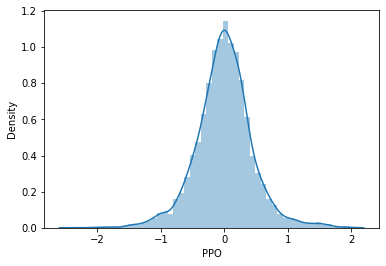

In [170]:
df['PPO'] = TA.PPO(ohlcv)['PPO'] - TA.PPO(ohlcv)['SIGNAL']
print(df['PPO'].describe())
sns.distplot(df['PPO'].dropna())
df.tail()

# ROC

count    5522.000000
mean        0.213744
std         4.685976
min       -23.361982
25%        -2.226075
50%         0.588853
75%         2.887686
max        23.364389
Name: ROC, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC
Date,,,,,,,,,,,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593,15772.115115,14605.256311,14440.529427,14141.877903,14068.335550,-129.709811,-33.463856,-114.309609,-0.787489,-8.852451
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078,15734.512195,14577.111104,14393.770833,14051.781950,14182.014299,-87.378344,-26.135031,-79.686942,-0.563993,-5.754718
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744,15703.386600,14529.794938,14346.289562,14018.192797,14209.159924,-83.790686,-30.249407,-57.770036,-0.423567,-5.507946
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940,15657.486114,14413.959974,14245.257140,13987.538105,14047.568251,-110.167836,-41.612264,-61.803871,-0.458199,-8.839260
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084,15619.038300,14396.103916,14247.692405,14005.370061,14137.639600,-71.753747,-20.659766,-32.996041,-0.267460,-7.868081


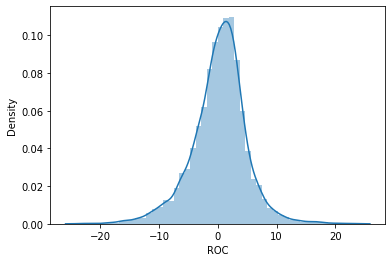

In [171]:
df['ROC'] = TA.ROC(ohlcv)
print(df['ROC'].describe())
sns.distplot(df['ROC'].dropna())
df.tail()

# CMFI

count    5.525000e+03
mean     2.960470e+10
std      1.645650e+10
min      0.000000e+00
25%      1.732259e+10
50%      3.680618e+10
75%      4.144593e+10
max      6.645785e+10
Name: CFI, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI
Date,,,,,,,,,,,,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593,15772.115115,14605.256311,14440.529427,14141.877903,14068.335550,-129.709811,-33.463856,-114.309609,-0.787489,-8.852451,4.083728e+10
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078,15734.512195,14577.111104,14393.770833,14051.781950,14182.014299,-87.378344,-26.135031,-79.686942,-0.563993,-5.754718,4.066815e+10
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744,15703.386600,14529.794938,14346.289562,14018.192797,14209.159924,-83.790686,-30.249407,-57.770036,-0.423567,-5.507946,4.047070e+10
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940,15657.486114,14413.959974,14245.257140,13987.538105,14047.568251,-110.167836,-41.612264,-61.803871,-0.458199,-8.839260,4.008797e+10
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084,15619.038300,14396.103916,14247.692405,14005.370061,14137.639600,-71.753747,-20.659766,-32.996041,-0.267460,-7.868081,3.977482e+10


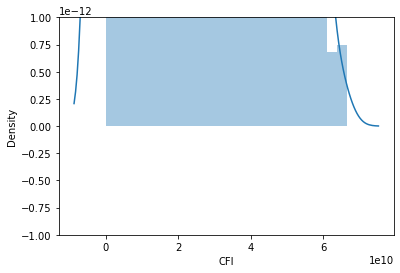

In [172]:
df['CFI'] = TA.CFI(ohlcv)
print(df['CFI'].describe())
sns.distplot(df['CFI'].dropna())
df.tail()

# DMI

count    5521.000000
mean       -0.371080
std        17.568310
min       -73.465234
25%       -12.397386
50%         0.180359
75%        11.623763
max        54.309679
Name: DMI, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI
Date,,,,,,,,,,,,,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593,15772.115115,14605.256311,14440.529427,14141.877903,14068.335550,-129.709811,-33.463856,-114.309609,-0.787489,-8.852451,4.083728e+10,-33.473704
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078,15734.512195,14577.111104,14393.770833,14051.781950,14182.014299,-87.378344,-26.135031,-79.686942,-0.563993,-5.754718,4.066815e+10,-26.734093
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744,15703.386600,14529.794938,14346.289562,14018.192797,14209.159924,-83.790686,-30.249407,-57.770036,-0.423567,-5.507946,4.047070e+10,-26.190089
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940,15657.486114,14413.959974,14245.257140,13987.538105,14047.568251,-110.167836,-41.612264,-61.803871,-0.458199,-8.839260,4.008797e+10,-33.042888
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084,15619.038300,14396.103916,14247.692405,14005.370061,14137.639600,-71.753747,-20.659766,-32.996041,-0.267460,-7.868081,3.977482e+10,-27.026426


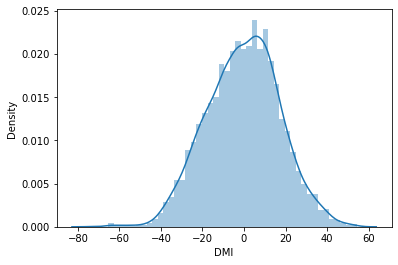

In [173]:
df['DMI'] = TA.DMI(ohlcv)['DI+'] - TA.DMI(ohlcv)['DI-']
print(df['DMI'].describe())
sns.distplot(df['DMI'].dropna())
df.tail()

# SAR

count     5534.000000
mean      8479.372261
std       2999.141098
min       3411.679932
25%       6322.406406
50%       8087.878274
75%       9620.460449
max      18619.609375
Name: SAR, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,...,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-07,14355.150391,13951.809570,14052.179688,14336.269531,3460100.0,0,33.444965,-78.362593,15772.115115,14605.256311,...,14141.877903,14068.335550,-129.709811,-33.463856,-114.309609,-0.787489,-8.852451,4.083728e+10,-33.473704,14698.518099
2022-07-08,14552.419922,14373.839844,14462.500000,14464.530273,3508600.0,0,36.183569,-71.144078,15734.512195,14577.111104,...,14051.781950,14182.014299,-87.378344,-26.135031,-79.686942,-0.563993,-5.754718,4.066815e+10,-26.734093,14552.419922
2022-07-11,14525.030273,14313.940430,14478.309570,14340.530273,2620100.0,0,34.697105,-77.603744,15703.386600,14529.794938,...,14018.192797,14209.159924,-83.790686,-30.249407,-57.770036,-0.423567,-5.507946,4.047070e+10,-26.190089,14552.419922
2022-07-12,14235.629883,13928.660156,14235.629883,13950.620117,3120000.0,0,30.459734,-98.728940,15657.486114,14413.959974,...,13987.538105,14047.568251,-110.167836,-41.612264,-61.803871,-0.458199,-8.839260,4.008797e+10,-33.042888,14525.030273
2022-07-13,14403.509766,14194.940430,14194.940430,14324.679688,0.0,0,38.250778,-77.078084,15619.038300,14396.103916,...,14005.370061,14137.639600,-71.753747,-20.659766,-32.996041,-0.267460,-7.868081,3.977482e+10,-27.026426,14405.756250


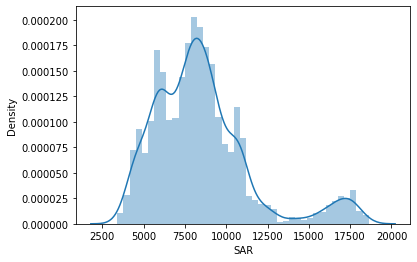

In [174]:
df['SAR'] = TA.SAR(ohlcv)
print(df['SAR'].describe())
sns.distplot(df['SAR'].dropna())
df.tail()

# columns選取

In [175]:
print(df.shape)
df = df.dropna(axis=0)#刪除有缺失的row,會缺失主要因為用時間rolling計算技術指標導致,正常的
features = df.columns[-15:].tolist() #取15個剛剛建立的技術指標當特徵
y_name = 'triple_barrier_signal' #當作labels
df = df[features+[y_name]]
print(df.shape)
df.tail()

(5534, 21)
(5494, 16)


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2022-07-07,33.444965,-78.362593,15772.115115,14605.256311,14440.529427,14141.877903,14068.335550,-129.709811,-33.463856,-114.309609,-0.787489,-8.852451,4.083728e+10,-33.473704,14698.518099,0
2022-07-08,36.183569,-71.144078,15734.512195,14577.111104,14393.770833,14051.781950,14182.014299,-87.378344,-26.135031,-79.686942,-0.563993,-5.754718,4.066815e+10,-26.734093,14552.419922,0
2022-07-11,34.697105,-77.603744,15703.386600,14529.794938,14346.289562,14018.192797,14209.159924,-83.790686,-30.249407,-57.770036,-0.423567,-5.507946,4.047070e+10,-26.190089,14552.419922,0
2022-07-12,30.459734,-98.728940,15657.486114,14413.959974,14245.257140,13987.538105,14047.568251,-110.167836,-41.612264,-61.803871,-0.458199,-8.839260,4.008797e+10,-33.042888,14525.030273,0
2022-07-13,38.250778,-77.078084,15619.038300,14396.103916,14247.692405,14005.370061,14137.639600,-71.753747,-20.659766,-32.996041,-0.267460,-7.868081,3.977482e+10,-27.026426,14405.756250,0


# 相關性分析

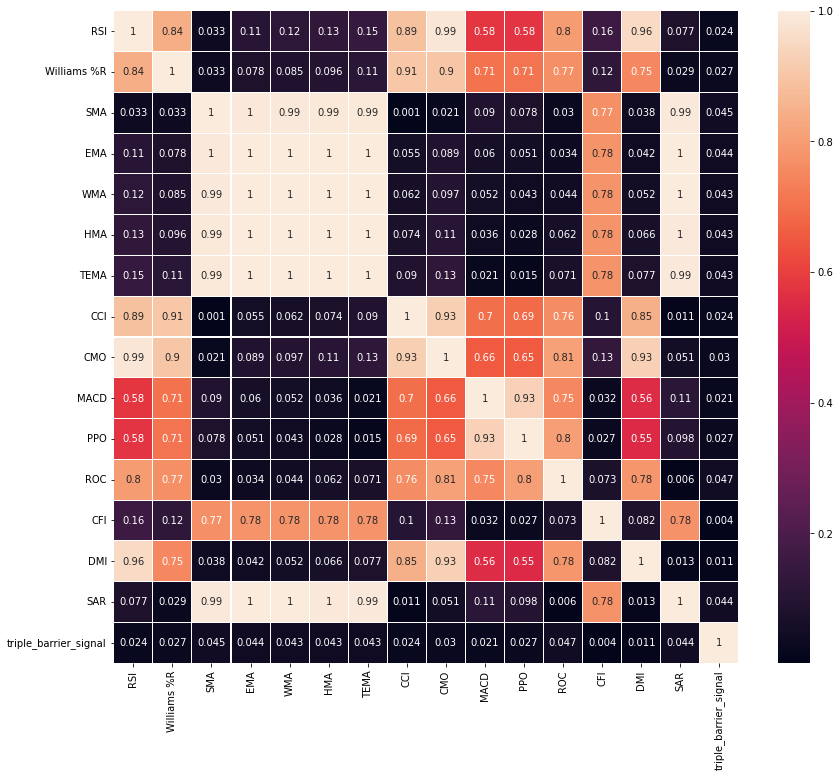

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1)

# features scaling

In [177]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(df)#縮放到0-1之間
df_minmax = pd.DataFrame(df_minmax,
                         index = df.index,
                         columns = df.columns)#轉回dataframe格式
df_minmax[y_name] = df[y_name]#y不用MinMaxScaler
df_minmax.tail()

,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2022-07-07,0.302635,0.216374,0.834960,0.745600,0.734299,0.711302,0.704799,0.352883,0.316218,0.323642,0.363690,0.310521,0.614484,0.312984,0.742168,0
2022-07-08,0.337908,0.288559,0.832333,0.743698,0.731153,0.705317,0.712343,0.404038,0.359945,0.409994,0.415515,0.376816,0.611939,0.365730,0.732561,0
2022-07-11,0.318762,0.223963,0.830158,0.740501,0.727958,0.703086,0.714144,0.408373,0.335397,0.464657,0.448077,0.382098,0.608968,0.369988,0.732561,0
2022-07-12,0.264186,0.012711,0.826951,0.732674,0.721160,0.701049,0.703421,0.376498,0.267602,0.454596,0.440047,0.310804,0.603209,0.316356,0.730760,0
2022-07-13,0.364533,0.229219,0.824265,0.731467,0.721323,0.702234,0.709398,0.422919,0.392612,0.526446,0.484276,0.331588,0.598497,0.363442,0.722917,0


In [178]:
df = df_minmax
print('特徵縮放完成!')

特徵縮放完成!


# Xs ,ys prepare

In [179]:
from tqdm import tqdm
import numpy as np

#定義觀察天數,起始index(0),結束index(資料筆數-觀察天數)
days = 15
b_index = 0
f_index = len(df)-days

#特徵欄位
features = df.drop(y_name,axis=1).columns.tolist()

#待存放序列
Xs = []
ys = []
indexs = []

'''
若資料筆數100,days=15天,f_index=85,i只會跑到84,i+days=99,features只會跑到98天.
若資料筆數100,days=15天,f_index=85+1,i會跑到85,i+days=100,features會跑到99天.
'''
for i in tqdm(range(b_index ,f_index+1 ,1)):#每次i都會遞增1
  X = df.iloc[i:i+days,:][features] #ex:0...14(不含15)之features
  y = df.iloc[i+days-1:i+days,:][y_name]#ex:14,y_name
  X = np.array(X) # to np_array
  Xs.append(X) #加入一筆X
  ys.append(y) #加入一筆y
  indexs.append((df.iloc[[i]].index,
                 df.iloc[[i+days-1]].index)) #加入資料日期
#轉換成np_array
Xs = np.array(Xs)
ys = np.array(ys)
print('準備完成')

100%|██████████| 5480/5480 [00:06<00:00, 894.10it/s]

準備完成


# check

In [180]:
print('資料筆數:',len(Xs))
print('第一筆的index開始和結束:{}-{}'.format(indexs[0][0].date[0],indexs[0][1].date[0]))
print('最後一筆的index開始和結束:{}-{}'.format(indexs[-1][0].date[0],indexs[-1][1].date[0]))

資料筆數: 5480
第一筆的index開始和結束:2000-03-08-2000-03-28
最後一筆的index開始和結束:2022-06-23-2022-07-13


# Reshape X

(圖片數量,長,寬,1張)

In [181]:
print(Xs.shape)
Xs = Xs.reshape(-1,days,len(features),1)
print(Xs.shape)

(5480, 15, 15)
(5480, 15, 15, 1)


# One hot encoding of label

原始y代表漲幅

In [182]:
print(ys.shape)
print(ys[:5])

from keras.utils.np_utils import to_categorical
ys = to_categorical(ys, num_classes = 3)
print(ys.shape)
print(ys[:5])

(5480, 1)
[[ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]]
(5480, 3)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


# Visualization

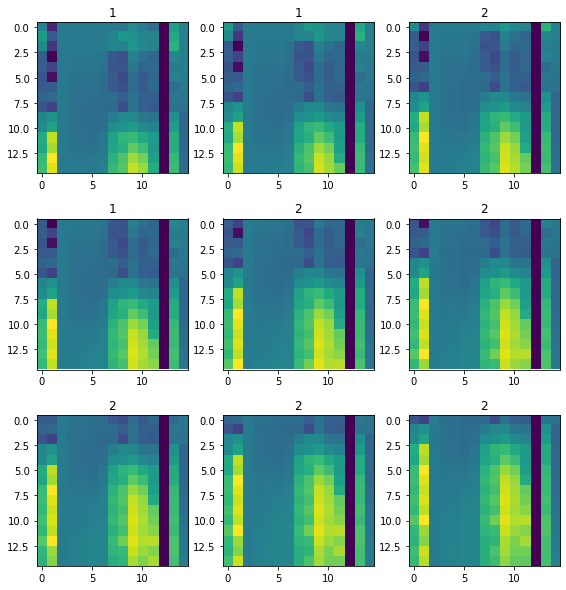

In [183]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
Xs_v = Xs.reshape(-1,Xs.shape[1],Xs.shape[2])
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(Xs_v[i])
    plt.title(np.argmax(ys[i]))

# Split training and test sets

In [184]:
X_test = Xs[-40:] #最後40天features當作test資料
X_train,y_train = Xs[:-40],ys[:-40] #其他當作訓練
print(X_train.shape,y_train.shape,X_test.shape)

(5440, 15, 15, 1) (5440, 3) (40, 15, 15, 1)


# 調整採樣

In [185]:
X_train2維 = X_train.reshape(X_train.shape[0],-1)
y_train數字 = np.array([ np.argmax(i) for i in y_train])
print(X_train2維.shape)
print(y_train數字.shape)

from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler()
X_train平衡 ,y_train平衡 = ros.fit_resample(X_train2維 ,y_train數字)
print(pd.DataFrame(y_train平衡)[0].value_counts().sort_index())#顯示結果

X_train = X_train平衡.reshape(X_train平衡.shape[0],15,15,1)#資料數,15,15,1
y_train = y_train平衡.reshape(y_train平衡.shape[0],1)#資料數,1
y_train = to_categorical(y_train , num_classes = 3)#one_hot
print(X_train.shape)
print(y_train.shape)

(5440, 225)
(5440,)
0    1093
1    1093
2    1093
Name: 0, dtype: int64
(3279, 15, 15, 1)
(3279, 3)


# Split training and val sets

In [186]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(X_train,
                                              y_train, 
                                              test_size = 0.2,
                                              random_state = 42,
                                              shuffle = True,#是否洗牌
                                              stratify = y_train #是否根據y欄位做分層取樣
                                             )
print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

(2623, 15, 15, 1) (2623, 3) (656, 15, 15, 1) (656, 3)


# 看一下樣本的label分布情況是否平均(待解決)

0:Hold,1:Buy,2:Sell

In [187]:
pd.Series([np.argmax(i) for i in ys]).value_counts()

1    2371
2    1997
0    1112
dtype: int64

In [188]:
pd.Series([np.argmax(i) for i in y_train]).value_counts()

0    1093
1    1093
2    1093
dtype: int64

In [189]:
pd.Series([np.argmax(i) for i in ytrain]).value_counts()

2    875
0    874
1    874
dtype: int64

In [190]:
pd.Series([np.argmax(i) for i in yval]).value_counts()

0    219
1    219
2    218
dtype: int64

# CNN

In [191]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from tensorflow.keras.optimizers import Adam #做梯度下降的一種優化方法
from keras.callbacks import ReduceLROnPlateau , EarlyStopping #減少學習速率 on Plateau

In [192]:
model = Sequential()

nclasses = 3 

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(15,15,1)))#15,15,32
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',))#15,15,64
model.add(MaxPool2D(pool_size=(5,5)))# 3,3,64
model.add(Flatten())#576
model.add(Dropout(0.5))#288
model.add(Dense(128, activation='relu'))#128
model.add(Dropout(0.5))#64
model.add(Dense(32, activation='relu'))#32
model.add(Dropout(0.5))#16
model.add(Dense(nclasses, activation='softmax'))#3
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 15, 15, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dropout_3 (Dropout)         (None, 576)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               73856     
                                                      

In [193]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 優化器

In [194]:
#1
lr_reduction = ReduceLROnPlateau(monitor = 'val_acc', 
                                 factor=0.5, 
                                 patience = 3, 
                                 verbose = 1, 
                                 min_lr = 0.00001)

#2
es = EarlyStopping(monitor='val_acc',#驗證集acc
                   min_delta=0, 
                   patience=50,  
                   mode='max',
                   restore_best_weights=True)#恢復最佳權重

# fit

In [195]:
history = model.fit(xtrain,ytrain,
                    batch_size = 128,
                    epochs = 500,
                    validation_data=(xval,yval),
                    verbose=1,callbacks=[es])

Epoch 1/500
21/21 [==============================] - 1s 15ms/step - loss: 1.1067 - accuracy: 0.3389 - val_loss: 1.0944 - val_accuracy: 0.3552
Epoch 2/500
21/21 [==============================] - 0s 7ms/step - loss: 1.0973 - accuracy: 0.3504 - val_loss: 1.0897 - val_accuracy: 0.4558
Epoch 3/500
21/21 [==============================] - 0s 7ms/step - loss: 1.0895 - accuracy: 0.3599 - val_loss: 1.0698 - val_accuracy: 0.4436
Epoch 4/500
21/21 [==============================] - 0s 8ms/step - loss: 1.0725 - accuracy: 0.3847 - val_loss: 1.0434 - val_accuracy: 0.4512
Epoch 5/500
21/21 [==============================] - 0s 8ms/step - loss: 1.0573 - accuracy: 0.4445 - val_loss: 1.0353 - val_accuracy: 0.4512
Epoch 6/500
21/21 [==============================] - 0s 7ms/step - loss: 1.0469 - accuracy: 0.4342 - val_loss: 1.0128 - val_accuracy: 0.4756
Epoch 7/500
21/21 [==============================] - 0s 7ms/step - loss: 1.0444 - accuracy: 0.4506 - val_loss: 1.0013 - val_accuracy: 0.4817
Epoch 8/500


# 訓練過程評估

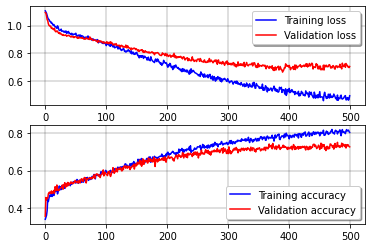

In [196]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

# 混淆矩陣

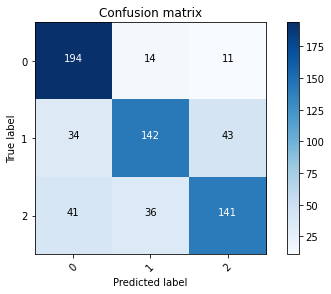

In [197]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#預測的y
ypred_onehot = model.predict(xval)
#轉換預測的y: [0 0 1 0 0 ...] --> 2
ypred = np.argmax(ypred_onehot,axis=1)
#轉換真實的y
ytrue = np.argmax(yval,axis=1)
#計算 confusion matrix
confusion_mtx = confusion_matrix(ytrue, ypred)
#畫出 confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(nclasses))

# 分類report

轉換預測結果

In [198]:
y_pred = model.predict(xval)
y_pred = [np.argmax(i) for i in y_pred]
y_pred = to_categorical(y_pred, num_classes = 3)
print(y_pred[:5])

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


真實y值

In [199]:
print(yval[:5])

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


# 分類報告

In [200]:
def 勝率(yval,y_pred):
  t = []
  for i,j in zip(yval,y_pred):
    t.append(np.allclose(i,j))
  return np.mean(t)
勝率(yval,y_pred)

0.7271341463414634

In [201]:
from sklearn.metrics import classification_report 
target_names = ['Hold','BUY','SELL']
print(classification_report(yval,y_pred,target_names=target_names))

              precision    recall  f1-score   support

        Hold       0.72      0.89      0.80       219
         BUY       0.74      0.65      0.69       219
        SELL       0.72      0.65      0.68       218

   micro avg       0.73      0.73      0.73       656
   macro avg       0.73      0.73      0.72       656
weighted avg       0.73      0.73      0.72       656
 samples avg       0.73      0.73      0.73       656



# plot error

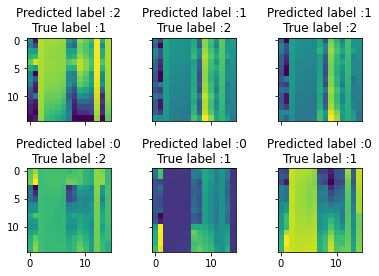

In [202]:
errors = (ypred - ytrue != 0)

ypred_er = ypred_onehot[errors]
ypred_classes_er = ypred[errors]
ytrue_er = ytrue[errors]
xval_er = xval[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    plt.subplots_adjust(wspace =0.5, hspace =0.5)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((days,len(features))))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
# 錯誤預測的概率
ypred_er_prob = np.max(ypred_er,axis=1)

# Predicted probabilities of the true values in the error set
true_prob_er = np.diagonal(np.take(ypred_er, ytrue_er, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_er = ypred_er_prob - true_prob_er

# Sorted list of the delta prob errors
sorted_delta_er = np.argsort(delta_pred_true_er)

# Top 6 errors. You can change the range to see other images
most_important_er = sorted_delta_er[-6:]

# Show the top 6 errors
display_errors(most_important_er, xval_er, ypred_classes_er, ytrue_er)

## 預測最後40筆

In [203]:
answer = model.predict(X_test)
answer = [ np.argmax(i) for i in answer]
print(len(answer))

40


# 0~20筆

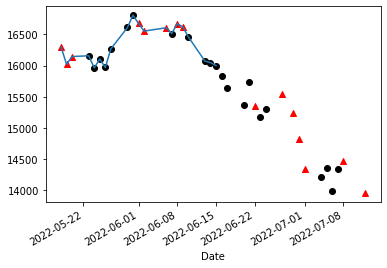

In [204]:
INDEX60 = df[-60:].index
C = web.DataReader(SID,'yahoo',start="2000-01-01")[['Close']]
C = C.loc[INDEX60,:]
C['SIGNAL'] = [np.nan for _ in range(20)] + answer #20個NAN+預測答案
buy = C[C['SIGNAL']==1]['Close']
sell = C[C['SIGNAL']==2]['Close']
C['Close'][20:40].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

# 20~40筆

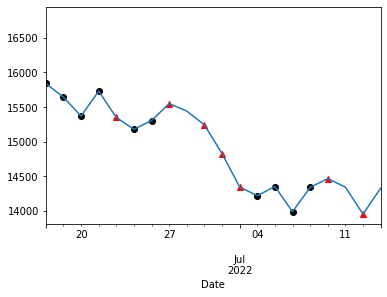

In [205]:
C['Close'][40:60].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

# 合併

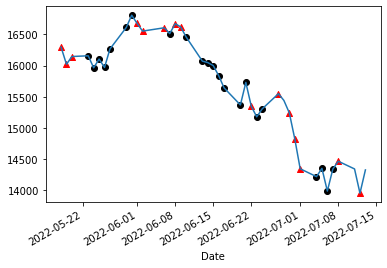

In [206]:
C['Close'][20:60].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

# 平滑版本

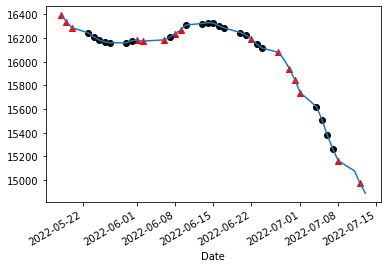

In [207]:
C_roll20 = pd.DataFrame(index=C.index)#空的dataframe index = 倒數60天股票日期
C_roll20['Close'] = C['Close'].rolling(20).mean()#收盤價做20天平滑
C_roll20['SIGNAL'] = C['SIGNAL']
buy = C_roll20[C_roll20['SIGNAL']==1]['Close']#買點
sell= C_roll20[C_roll20['SIGNAL']==2]['Close']#賣點
C_roll20['Close'][20:].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

In [208]:
C = C.dropna(axis=0)
C

,Close,SIGNAL
Date,,
2022-05-18,16296.860352,1.0
2022-05-19,16020.320312,1.0
2022-05-20,16144.849609,1.0
2022-05-23,16156.410156,2.0
2022-05-24,15963.629883,2.0
2022-05-25,16104.030273,2.0
2022-05-26,15968.830078,2.0
2022-05-27,16266.219727,2.0
2022-05-30,16610.619141,2.0


In [209]:
np.set_printoptions(suppress=True)
C['HOLD%'] = model.predict(X_test)[:,0]
C['BUY%'] = model.predict(X_test)[:,1]
C['SELL%'] = model.predict(X_test)[:,2]
C.tail(40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Close,SIGNAL,HOLD%,BUY%,SELL%
Date,,,,,
2022-05-18,16296.860352,1.0,3.746255e-01,0.522560,0.102814
2022-05-19,16020.320312,1.0,2.355042e-01,0.485108,0.279388
2022-05-20,16144.849609,1.0,2.067344e-01,0.513809,0.279457
2022-05-23,16156.410156,2.0,4.884750e-02,0.450065,0.501087
2022-05-24,15963.629883,2.0,5.694394e-04,0.170733,0.828697
2022-05-25,16104.030273,2.0,7.353605e-04,0.176216,0.823049
2022-05-26,15968.830078,2.0,1.548506e-05,0.054026,0.945958
2022-05-27,16266.219727,2.0,2.973519e-05,0.026282,0.973688
2022-05-30,16610.619141,2.0,7.434140e-04,0.150226,0.849031


In [210]:
def 勝率(df):
  t = []
  for i,idx in enumerate(df.index):
    訊號 = np.argmax(df.iloc[i,-3:])
    if 訊號 == 1:#buy
      try:
        點差 = df.iloc[i+1,0] - df.iloc[i,0]
        if 點差>0:
          t.append(True)
        else:
          t.append(False)
      except:
        pass
    if 訊號 == 2:#sell
      try:
        點差 = df.iloc[i,0] - df.iloc[i+1,0]
        if 點差<0:
          t.append(True)
        else:
          t.append(False)
      except:
        pass
    if 訊號 == 0:#hold
      pass
  return np.mean(t)
#C['Close'].shift()-C['Close'],len(C['Close'].shift()-C['Close'])
勝率(df)

0.6253654970760234

In [211]:
t = []
for i in range(len(C)):
  signal = np.argmax(C.iloc[i,-3:])
  if signal == 2:
    signal = -1
    t.append(signal)
  if signal == 1:
    signal = 1
    t.append(signal)
  if signal == 0:
    t.append(signal)
t,len(t)

([1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  1,
  1,
  -1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  1,
  0,
  1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  1,
  0,
  1,
  0],
 40)

In [216]:
a = (C['Close'].shift()-C['Close']).values*t
平均獲利 = pd.Series((a>0)*a).dropna().mean()
平均損失 = pd.Series((a<0)*a).dropna().mean()
賠率 = 1-勝率(df)
print(勝率(df),平均獲利,賠率,平均損失)
分子 = 勝率(df)*平均獲利
分母 =  賠率*平均損失*-1
print(分子,分母)
盈虧比 = (分子)/(分母)
盈虧比

0.6253654970760234 113.08433493589743 0.3746345029239766 -78.05999599358974
70.71904132869902 29.243967797306095


2.418243715041074

In [217]:
賠率

0.3746345029239766

# save model

In [221]:
model.save('Rikcy_net.h5')
del model

In [222]:
from keras.models import load_model
model = load_model('Rikcy_net.h5')
predict = model.predict(X_test)

In [223]:
predict[-5:]

array([[0.00103167, 0.26934883, 0.72961956],
       [0.01358342, 0.5999287 , 0.38648784],
       [0.68633974, 0.29444817, 0.01921212],
       [0.20360325, 0.7253409 , 0.07105589],
       [0.6101075 , 0.38827166, 0.00162086]], dtype=float32)